In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
%matplotlib inline

In [2]:
def calibrate_camera():
    image_names = glob.glob('./camera_cal/calibration*.jpg')
    # Arrays to store object points and image points from all the images
    objpoints = [] # 3D points in real world space
    imgpoints = [] # 2D points in image plane

    objp = np.zeros((6*9, 3), np.float32)
    objp[:, :2] = np.mgrid[0:9, 0:6].T.reshape(-1, 2) # x, y coordinates

    for fname in image_names:
        # Read in image
        img = mpimg.imread(fname)

        # Convert img to grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9, 6), None)

        # If found, draw corners
        if ret == True:
            # Add points to objpoints and imgpoints arrays
            objpoints.append(objp)
            imgpoints.append(corners)
            # Draw and display the corners
            cv2.drawChessboardCorners(img, (9, 6), corners, ret)
#             plt.imshow(img)
#             plt.show()
    return objpoints, imgpoints

def undistort(img, objpoints, imgpoints):
    # Read in each image
    # Convert image to grayscale
    gray_raw = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Use cv2.calibrateCamera and cv2.undistort()
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray_raw.shape, None, None)

    undistorted = cv2.undistort(img, mtx, dist, None, mtx)
    
    return undistorted

In [3]:
# Simple grayscale gradient
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    orient_to_params = {'x': (1, 0), 'y': (0, 1)}
    sobel = np.abs(cv2.Sobel(img, cv2.CV_64F, orient_to_params[orient][0], orient_to_params[orient][1], ksize=sobel_kernel))
    scaled_sobel = np.uint8(255*sobel/np.max(sobel))
    grad_binary = np.zeros_like(scaled_sobel)
    grad_binary[(scaled_sobel > thresh[0]) & (scaled_sobel < thresh[1])] = 1

    return grad_binary

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Calculate gradient magnitude
    # Apply threshold
    sobel_x = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobel_y = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    sobel = (sobel_x**2 + sobel_y**2)**0.5

    scaled_sobel = np.uint8(255*sobel/np.max(sobel))
    
    mag_binary = np.zeros_like(scaled_sobel)
    mag_binary[(scaled_sobel > mag_thresh[0]) & (scaled_sobel < mag_thresh[1])] = 1    

    return mag_binary

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Calculate gradient direction
    # Apply threshold
    sobel_x = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobel_y = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)

    abs_sobel_x = np.abs(sobel_x)
    abs_sobel_y = np.abs(sobel_y)
    
    direction = np.arctan2(abs_sobel_y, abs_sobel_x)

    dir_binary = np.zeros_like(direction)
    dir_binary[(direction > thresh[0]) & (direction < thresh[1])] = 1

    return dir_binary

In [4]:
def perspective_transform(img):
    img_size = (img.shape[1], img.shape[0])

    src = np.float32(
            [[676, 445], # Top right
             [1031, 671],# Bottom right
             [274, 671], # Bottom left
             [602, 445]  # Top left           
            ]
        )
        
    offset = 0
    
    dst = np.float32(
        [[950, 0 - offset],
         [950, img_size[1] + offset],
         [300, img_size[1] + offset],
         [300, 0 - offset]
        ]
    )
    
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    
    return M, Minv, warped

In [5]:
def draw_area(source_img, binary_warped_img, Minv):
#     print(source_img.shape, binary_warped_img.shape)
    # Use the bottom half of the binary warped image to roughly locate the centers of the lanes
    histogram = np.sum(binary_warped_img[binary_warped_img.shape[0]/2:,:], axis=0)

    # Make the color version of the binary warped img
    out_img = np.dstack((binary_warped_img, binary_warped_img, binary_warped_img))*255

    # Split the histogram in half to identify the left lane and the right lane
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9

    # Set height of windows, calulated based on nwindows
    window_height = np.int(binary_warped_img.shape[0]/nwindows)
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped_img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped_img.shape[0] - (window+1)*window_height
        win_y_high = binary_warped_img.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
#         cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
#         cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
        
    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # At this point, you're done! But here is how you can visualize the result as well:
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped_img.shape[0]-1, binary_warped_img.shape[0] )
    left_fitx = left_fit[0] * ploty**2 + left_fit[1] * ploty + left_fit[2]
    right_fitx = right_fit[0] * ploty**2 + right_fit[1] * ploty + right_fit[2]

    lane_center = (left_fitx[-1] + right_fitx[-1]) / 2
    car_center = source_img.shape[1] / 2  
    deviation_px = car_center - lane_center
    
#     print(deviation_px)
    
#     out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
#     out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
#     plt.imshow(out_img)
#     plt.plot(left_fitx, ploty, color='yellow')
#     plt.plot(right_fitx, ploty, color='yellow')
#     plt.xlim(0, 1280)
#     plt.ylim(720, 0)

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

#     Draw the lane onto the warped blank image
#     cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
#     cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
#     result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
#     font = cv2.FONT_HERSHEY_SIMPLEX
#     cv2.putText(result,'Radius of Road: ' + str(round(radius, 2)) + 'm', (490, 80), font, 1.2, (220,220,220),2)
    
#     plt.figure(figsize=(8, 4.5))
#     plt.imshow(result)
#     plt.plot(left_fitx, ploty, color='yellow')
#     plt.plot(right_fitx, ploty, color='yellow')
#     plt.xlim(0, 1280)
#     plt.ylim(720, 0)
#     plt.show()

    y_eval = np.max(ploty)
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
#     print(left_curverad, right_curverad)

    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 32/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    deviation_meter = xm_per_pix * deviation_px
    
#     radius = (left_curverad + right_curverad) / 2
# #     cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
# #     cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
# #     result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
# #     font = cv2.FONT_HERSHEY_SIMPLEX
# #     cv2.putText(result,'Radius of Road: ' + str(round(radius, 2)) + 'm', (490, 80), font, 1.2, (220,220,220),2)
    
# #     plt.figure(figsize=(8, 4.5))
# #     plt.imshow(result)
# #     plt.plot(left_fitx, ploty, color='yellow')
# #     plt.plot(right_fitx, ploty, color='yellow')
# #     plt.xlim(0, 1280)
# #     plt.ylim(720, 0)
# #     plt.show()
    
#     print(deviation_meter)
    # Now our radius of curvature is in meters
#     print(left_curverad, 'm', right_curverad, 'm')
# # Example values: 632.1 m    626.2 m
    
    gray_raw = cv2.cvtColor(source_img, cv2.COLOR_RGB2GRAY)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray_raw.shape, None, None)
    undist = cv2.undistort(source_img, mtx, dist, None, mtx)

    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped_img).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0, 0, 255))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (gray_raw.shape[1], gray_raw.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    
    return result, left_curverad, right_curverad, deviation_meter

In [6]:
objpoints, imgpoints = calibrate_camera()

def pipeline(img):
    """
    Masks used:
    1. Calibrate camera
    2. Undistort image
    1. Grayscale gradient binary, combined
    2. Red channel binary
    3. S channel binary
    4. L channel binary
    5. Combine 1~4
    6. Apply mask to mark the region of interest
    """
    img = undistort(img, objpoints, imgpoints)
    
    # Grayscale combined
    ksize = 31
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    gradx = abs_sobel_thresh(gray, orient='x', sobel_kernel=ksize, thresh=(50, 255))
    grady = abs_sobel_thresh(gray, orient='y', sobel_kernel=ksize, thresh=(50, 255))
    mag_binary = mag_thresh(gray, sobel_kernel=ksize, mag_thresh=(50, 255))
    dir_binary = dir_threshold(gray, sobel_kernel=ksize, thresh=(1 * np.pi/8, 3 * np.pi/8))

    combined = np.zeros_like(gray)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    
    # Get red binary
    r_channel = img[:, :, 0]
    g_channel = img[:, :, 1]
    b_channel = img[:, :, 2]
    
    red_binary = np.zeros_like(r_channel)
    red_binary[(r_channel > 150) & (r_channel < 255)] = 1
    
    # Get saturation/lightness binary
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    
    h_channel = hls[:, :, 0]
    l_channel = hls[:, :, 1]
    s_channel = hls[:, :, 2]
    
    sat_binary = np.zeros_like(s_channel)
    sat_binary[(s_channel > 120) & (s_channel < 255)] = 1
    
    lit_binary = np.zeros_like(l_channel)
    lit_binary[(l_channel > 110) & (l_channel < 200)] = 1
    
    # Stack of sat_binary and combined
    color_binary = np.dstack((np.zeros_like(s_channel), sat_binary, combined))
    
    # Combine all binaries
    combine_all = np.zeros_like(combined)
#     combine_all[((sat_binary == 1) | (lit_binary == 1)| (combined == 1)) | (red_binary == 1) ] = 1
    combine_all[((sat_binary == 1) | (combined == 1))] = 1
        
    ca_color = np.dstack((combine_all, combine_all, combine_all)).astype(np.float)
    ca_color = np.uint8(255 * ca_color / np.max(ca_color))
#     print(ca_color.shape)
    
    M, Minv, warped = perspective_transform(combine_all)
    
    warped[(warped > 0)] = 1
    
    # Cropping
    warped[:, :150] = 0
    warped[:, warped.shape[1] - 150:] = 0
    
    result, left_curverad, right_curverad, deviation_meter = draw_area(img, warped, Minv)
    radius = (left_curverad + right_curverad) / 2
    
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(result,'Radius of Road: ' + str(round(radius, 2)) + 'm', (490, 80), font, 1.2, (220,220,220),2)
    cv2.putText(result,'Deviation from Center: ' + str(round(deviation_meter, 2)) + 'm', (490, 127), font, 1.2, (220,220,220),2)
    cv2.rectangle(result, (475, 40), (1195, 143), (120, 120, 120), thickness=2)
    
    return result

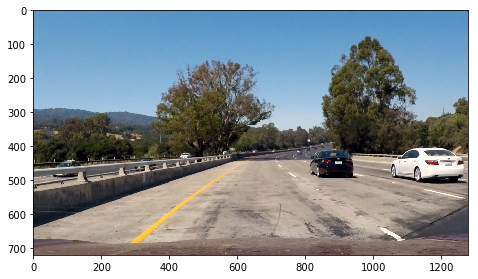

/home/calvinjku/anaconda3/envs/CarND-Term1/lib/python3.5/site-packages/ipykernel/__main__.py:4: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


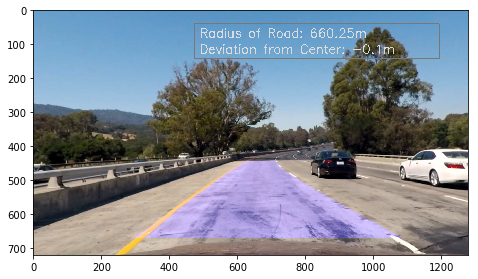

In [7]:
test = plt.imread('./test_images/test1.jpg')
plt.figure(figsize=(8, 4.5))
plt.imshow(test)
plt.show()

result = pipeline(test)

plt.figure(figsize=(8, 4.5))
plt.imshow(result)
plt.show()

In [131]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

white_output = 'fourth_try.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(pipeline) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video fourth_try.mp4
[MoviePy] Writing video fourth_try.mp4




  0%|          | 0/1261 [00:00<?, ?it/s]

  0%|          | 1/1261 [00:03<1:15:58,  3.62s/it]

  0%|          | 2/1261 [00:07<1:15:50,  3.61s/it]

  0%|          | 3/1261 [00:10<1:15:33,  3.60s/it]

  0%|          | 4/1261 [00:15<1:19:31,  3.80s/it]

  0%|          | 5/1261 [00:19<1:20:47,  3.86s/it]

  0%|          | 6/1261 [00:23<1:21:58,  3.92s/it]

  1%|          | 7/1261 [00:26<1:21:01,  3.88s/it]

  1%|          | 8/1261 [00:30<1:19:33,  3.81s/it]

  1%|          | 9/1261 [00:34<1:19:37,  3.82s/it]

  1%|          | 10/1261 [00:38<1:18:33,  3.77s/it]

  1%|          | 11/1261 [00:41<1:17:41,  3.73s/it]

  1%|          | 12/1261 [00:45<1:17:13,  3.71s/it]

  1%|          | 13/1261 [00:49<1:18:05,  3.75s/it]

  1%|          | 14/1261 [00:52<1:17:42,  3.74s/it]

  1%|          | 15/1261 [00:56<1:17:14,  3.72s/it]

  1%|▏         | 16/1261 [01:00<1:18:04,  3.76s/it]

  1%|▏         | 17/1261 [01:04<1:20:26,  3.88s/it]

  1%|▏         | 18/1261 [01:08<1:19:18,  3.83s/it]

  2%|▏     

[MoviePy] Done.
[MoviePy] >>>> Video ready: fourth_try.mp4 

CPU times: user 1h 36min 56s, sys: 10.9 s, total: 1h 37min 7s
Wall time: 1h 21min 28s
